# 01_summary_statistics.ipynb

In [1]:
import contextily as cx
import figure_utilities
import figure_and_table_constants
import constants
from stats_utilities import produce_summary_statistics
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import os
import pandas as pd

# Store paths.
INPUT_DATA_UNRESTRICTED = "../../data/03_cleaned/unrestricted_monthly.parquet"
INPUT_DATA_RESTRICTED = "../../data/03_cleaned/crime_analysis_monthly.parquet"
INPUT_DATA_TRACTS = "../../data/02_intermediate/tracts.csv"
INPUT_DATA_BOSTON_TRACTS_SHAPEFILE = "../../data/01_raw/Census_2010_Tracts"

OUTPUT_TABLES = "../../output/summary_statistics/tables"
OUTPUT_FIGURES = "../../output/summary_statistics/figures"

# Read unrestricted dataset into memory.
unrestricted_df = pd.read_parquet(INPUT_DATA_UNRESTRICTED)

# Drop malformed addresses.
unrestricted_df = unrestricted_df.loc[~unrestricted_df['property_address_full'].str.contains("span, span span"), :]

# So we can use 'case_number' like a column
unrestricted_df = unrestricted_df.reset_index()

# Restrict to Boston evictions.
boston_mask = ((unrestricted_df['County'] == "Suffolk County") & (~unrestricted_df['City'].isin(["Chelsea", "Revere", "Winthrop"])))
unrestricted_df = unrestricted_df.loc[boston_mask, :]

unrestricted_df = unrestricted_df.loc[unrestricted_df['latest_docket_month'].isin(['2019-06',
                                            '2019-07',
                                            '2019-08',
                                            '2019-09',
                                            '2019-10',
                                            '2019-11',
                                            '2019-12',
                                            '2020-01',
                                            '2020-02',
                                            '2020-03']), :]

/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_35542/156149417.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from P

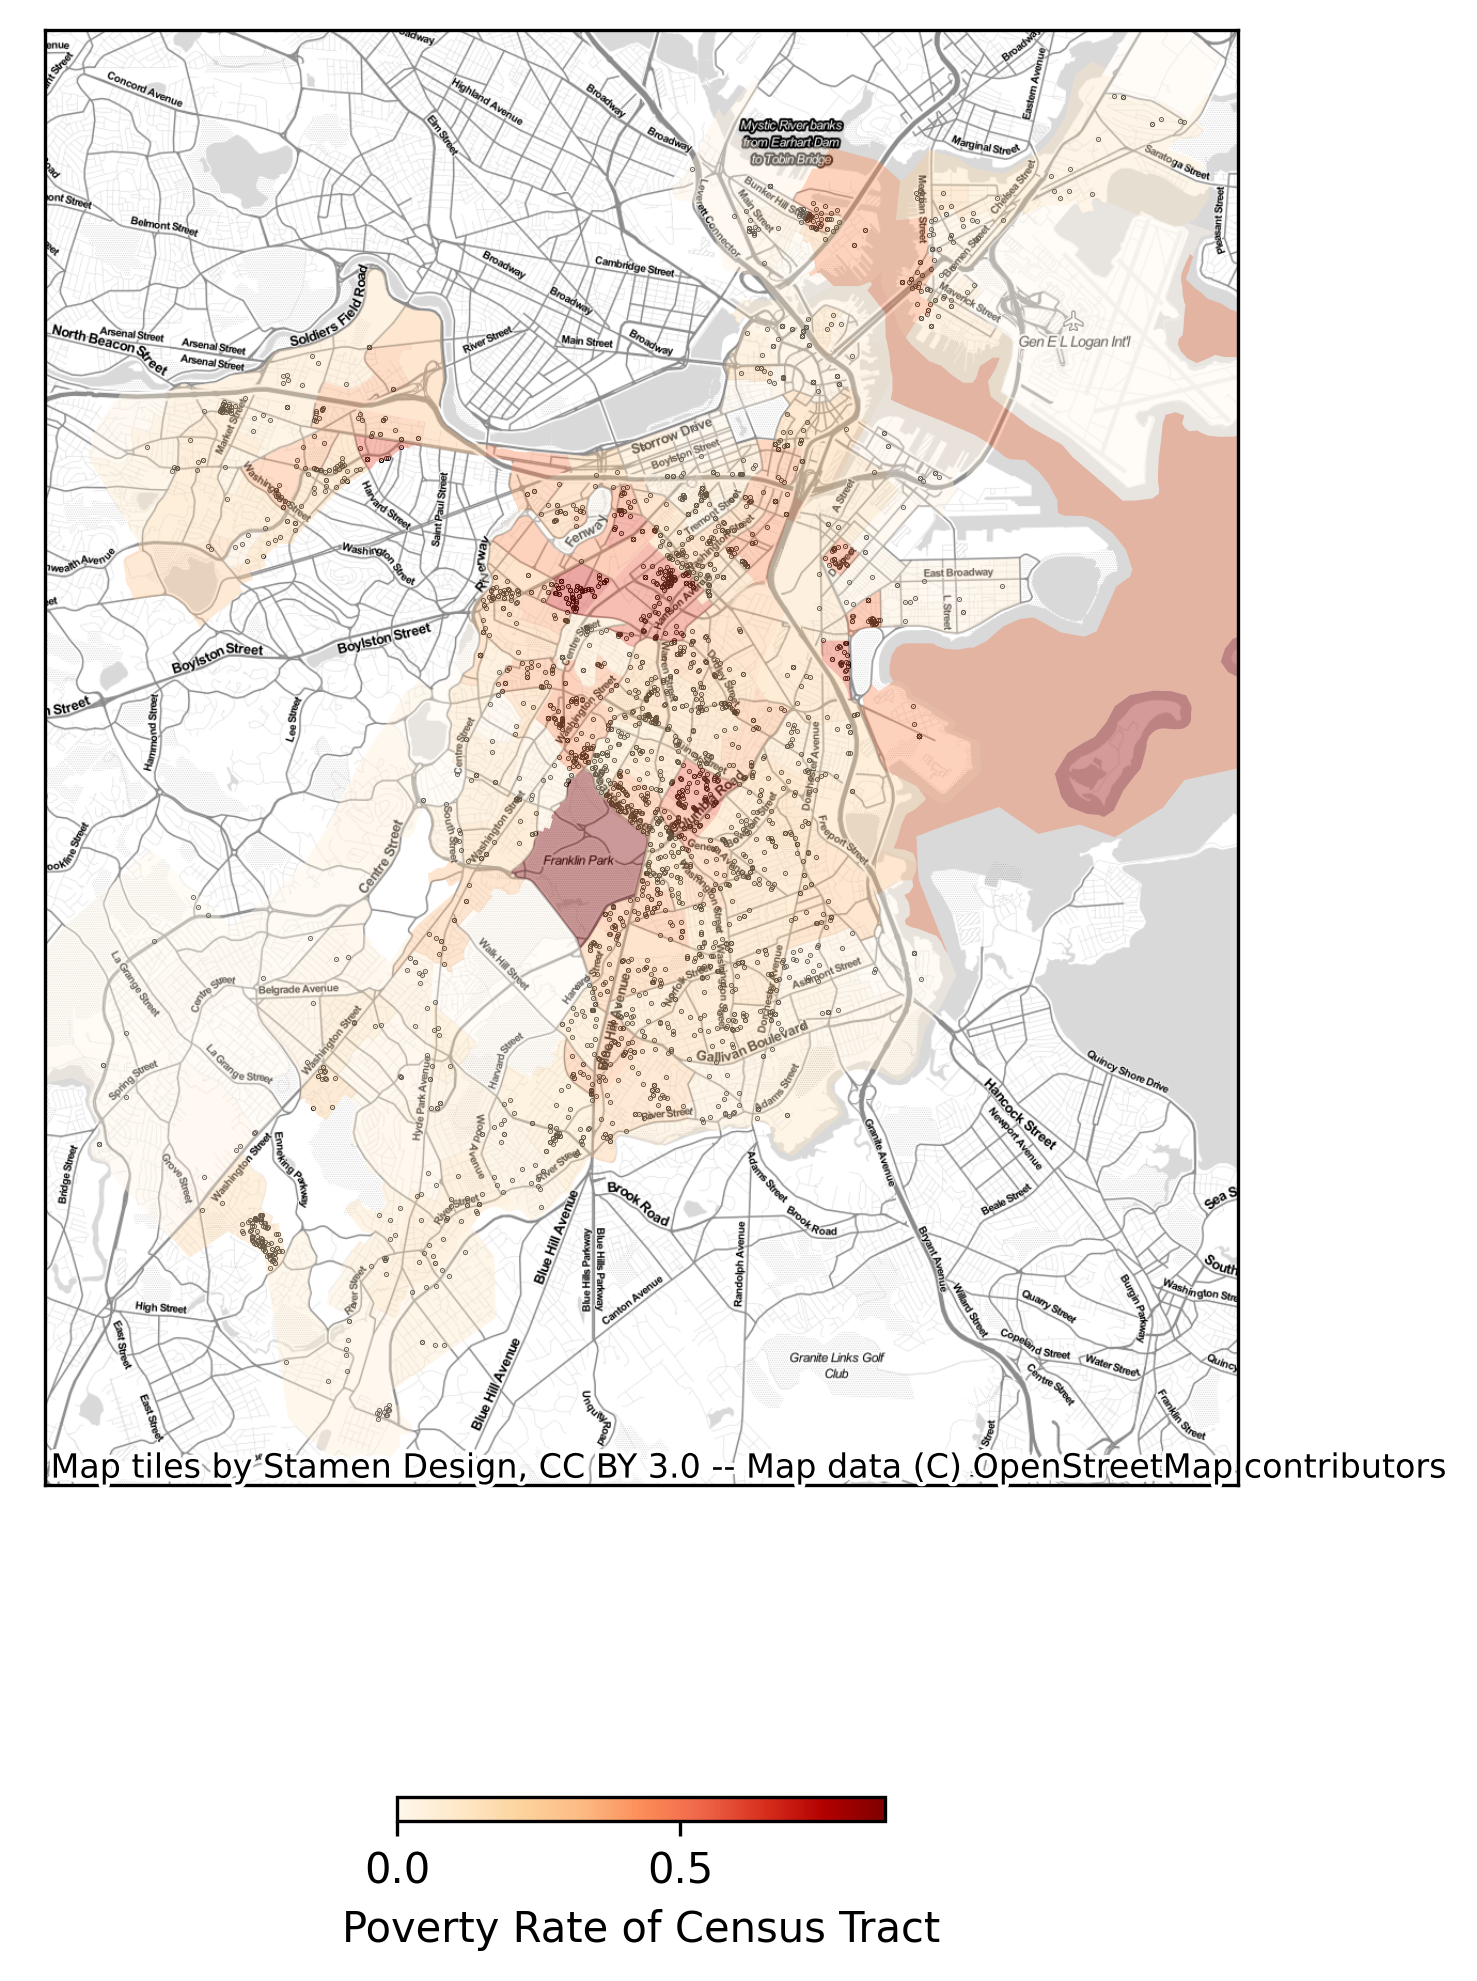

In [2]:
# Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(unrestricted_df,
                                    geometry=gpd.points_from_xy(unrestricted_df['longitude'],
                                                                unrestricted_df['latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(7, 9))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color='black',
                      markersize=0.05)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)

# Color census tracts by poverty rate.
boston_tracts_gdf = gpd.read_file(INPUT_DATA_BOSTON_TRACTS_SHAPEFILE)[['GEOID10', 'geometry']].set_index('GEOID10')
boston_tracts_gdf.index = boston_tracts_gdf.index.astype(int)
tract_poverty_rates_df = pd.read_csv(INPUT_DATA_TRACTS, usecols=['tract_geoid', 'poor_share2010'], index_col='tract_geoid')

boston_tracts_gdf = pd.concat([boston_tracts_gdf, tract_poverty_rates_df], axis=1).dropna(subset=['geometry', 'poor_share2010'])
boston_tracts_gdf.plot(ax=ax, column=boston_tracts_gdf['poor_share2010'], cmap='OrRd', alpha=0.4, legend=True, legend_kwds={'label': "Poverty Rate of Census Tract",
                                                                                                               'orientation': "horizontal",
                                                                                                               'shrink': 0.3})


plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

In [ ]:
# Plot the number of eviction filings over time.
unrestricted_df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(unrestricted_df['file_date']) +
                                                    pd.tseries.offsets.MonthEnd(0))
filings_per_month = unrestricted_df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color=figure_and_table_constants.Colors.SUMMARY_STATISTICS_COLOR,
                       zorder=100)
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)

# Plot the beginning and end of the CARES act moratorium.
CARES_beginning = pd.Timestamp("2020-03-27")
CARES_end = pd.Timestamp("2020-08-23")
CARES_color = figure_and_table_constants.Colors.P1
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_beginning, text='', color=CARES_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_end, text='', color=CARES_color)
ax.axvspan(CARES_beginning, CARES_end, color=CARES_color, alpha=0.5)

# Plot the beginning and end of the CDC moratorium.
CDC_beginning = pd.Timestamp("2020-09-04")
CDC_end = pd.Timestamp("2021-08-26")
CDC_color = figure_and_table_constants.Colors.P2
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_beginning, text='', color=CDC_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_end, text='', color=CDC_color)
ax.axvspan(CDC_beginning, CDC_end, color=CDC_color, alpha=0.5)

# Plot the beginning and end of the MA state moratorium.
MA_beginning = pd.Timestamp("2020-04-20")
MA_end = pd.Timestamp("2020-10-17")
MA_color = figure_and_table_constants.Colors.P7
figure_utilities.plot_labeled_vline(ax=ax, x=MA_beginning, text='', color=MA_color)
figure_utilities.plot_labeled_vline(ax=ax, x=MA_end, text='', color=MA_color)
ax.axvspan(MA_beginning, MA_end, color=MA_color, alpha=0.5)

# Build legend.
legend_elements = [Line2D([0], [0], color='black', label='Evictions per Month'),
                   Patch(facecolor=CARES_color, edgecolor=CARES_color, label='CARES Act Eviction Moratorium',
                         alpha=0.5, linestyle='--'),
                   Patch(facecolor=MA_color, edgecolor=MA_color, label='MA Bill H.4647', alpha=0.5,
                         linestyle='--'),
                   Patch(facecolor=CDC_color, edgecolor=CDC_color, label='CDC Eviction Moratorium', alpha=0.5,
                         linestyle='--')]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))

In [ ]:
# Produce summary statistics for unrestricted sample.
treatment_date_variable = 'latest_docket_date'
outcomes_of_interest = ['group_0_crimes_500m']
summary_statistics_unrestricted, variable_display_names_dict  = produce_summary_statistics(unrestricted_df,
                                                                                           treatment_date_variable=treatment_date_variable)

# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N", '50%': 'Median'}

summary_statistics_unrestricted = summary_statistics_unrestricted.sort_values(['Panel', 'Variable'])
# Keep only outcomes of interest
outcomes = constants.Variables.outcomes.copy()
for outcome in outcomes:
    if outcome not in outcomes_of_interest:
        if f"pre_treatment_change_in_{outcome}" in summary_statistics_unrestricted.index.get_level_values(1):
            summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f"pre_treatment_change_in_{outcome}", level=1, axis=0)
        if f"total_twenty_seventeen_{outcome}" in summary_statistics_unrestricted.index.get_level_values(1):
            summary_statistics_unrestricted = summary_statistics_unrestricted.drop(f"total_twenty_seventeen_{outcome}", level=1, axis=0)

# Drop Panel F.
summary_statistics_unrestricted = summary_statistics_unrestricted.drop("Panel F: Post-treatment Outcomes", level=0, axis=0)

# Drop median column.
summary_statistics_unrestricted = summary_statistics_unrestricted.drop(columns='50%')


# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .rename(index=variable_display_names_dict)
         .rename(columns=column_display_names_dict)
         .style
         .format(formatter={
                            'Mean': "{:,.2f}",
                            'Median': "{:,.2f}",
                            'S.D.': "{:,.2f}",
                            'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

In [ ]:
# Load restricted data.
restricted_df = pd.read_parquet(INPUT_DATA_RESTRICTED).reset_index()
restricted_df = restricted_df.loc[restricted_df['latest_docket_month'].isin(['2019-06',
                                                                                   '2019-07',
                                                                                   '2019-08',
                                                                                   '2019-09',
                                                                                   '2019-10',
                                                                                   '2019-11',
                                                                                   '2019-12',
                                                                                   '2020-01',
                                                                                   '2020-02',
                                                                                   '2020-03']), :]

In [ ]:
treatment_timings = (restricted_df
                     .groupby(['latest_docket_month', 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
treatment_timings = treatment_timings.pivot(index='latest_docket_month', columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings['Cases Won By Defendant']) / len(restricted_df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
treatment_timings.index = treatment_timings.index.rename("Last Docket Date")

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={'Cases Won By Plaintiff': '{:,.0f}',
                                          'Cases Won By Defendant': '{:,.0f}',
                                          'Portion of All Cases': '{:0.2f}'}).to_latex(filename, column_format="lccc", hrules=True)
treatment_timings